In [2]:
import os
import numpy as np
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from metric_learn import LMNN
from sklearn.model_selection import train_test_split

In [4]:
lastfm_files = []
suno_files = []
udio_files = []

# splits = ['train', 'val', 'test']
splits = ['test']

for split in splits:
    with open(f'/home/laura/aimir/lastfm/{split}.txt', 'r') as f:
        lastfm_files += f.read().splitlines()
    with open(f'/home/laura/aimir/suno/{split}.txt', 'r') as f:
        suno_files += f.read().splitlines()
    with open(f'/home/laura/aimir/udio/{split}.txt', 'r') as f:
        udio_files += f.read().splitlines()

iter | objective | objective difference | active constraints | learning rate
2 947543.4746364341 -198555.75630033575 6938944 1.0099999999999999e-07
3 816041.5023444388 -131501.9722919953 6011796 1.0201e-07
4 722948.9397563695 -93092.56258806936 5334910 1.030301e-07
5 653257.9528020751 -69690.98695429438 4819000 1.0406040099999999e-07
6 598782.6708920109 -54475.281910064165 4411349 1.0510100500999999e-07
7 554766.7295132121 -44015.9413787988 4079177 1.0615201506009999e-07
8 518303.1335992147 -36463.595913997386 3802119 1.0721353521070098e-07
9 487488.54309671605 -30814.59050249867 3567291 1.08285670562808e-07
10 461014.01794567425 -26474.525151041802 3364585 1.0936852726843608e-07
11 437958.96832833905 -23055.0496173352 3188195 1.1046221254112044e-07
12 417655.804944003 -20303.163384336047 3031641 1.1156683466653164e-07
13 399611.4255103378 -18044.37943366519 2892666 1.1268250301319696e-07
14 383433.37602307484 -16178.049487262964 2768315 1.1380932804332893e-07
15 368817.4081965571 -146

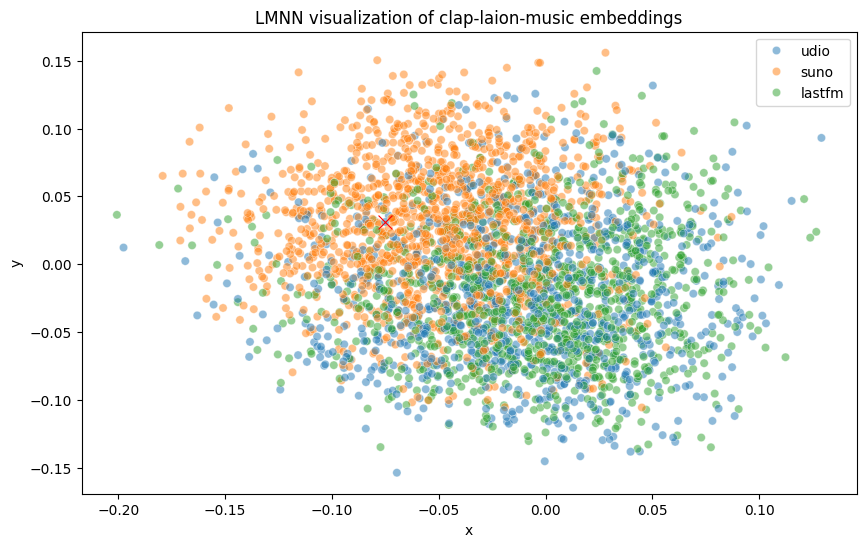

2d785b99a47e1fd2a1a3c004c5106dbe: udio
88baae54ebbbea2e0c9539e8ee01cd7a: suno
e20047fa7c0ace91b7148c8c7e9e4347: udio
8988a48f7e106b98d88549fbd5e72f77: lastfm
62129c32ed88fa64819821d74cc0e7f3: lastfm
97958af520e01128db10710a8226bfc4: lastfm
7b1e7e670fdf94e438b6190c59770b35: lastfm
b79eb2441f2bea6a36c239ef84f6f9d1: suno
b0655f5f39eecded6005c6ba1675c163: suno
54f9b3a670ff5042fae7b28041349d76: udio
ad5c250b81e09fb53159f85d8793d14e: suno
cd281b3b4430ec567a4186837e5b0f27: udio
5e2881d03684151961ae26df85834619: suno
db94e8471a43286a8d89aa8759bc8a6c: suno
4b6adf727bb00cea76aab23c47a9ceb2: suno
d4f6df98505248c06a7a622e73214130: udio
5850b04522e3b40f1325a9cabcee9b5b: lastfm
fda8dcd60f3042019ff7553730c2eb90: lastfm
87c5826b24661ae306a879f9b3a4897f: suno
4cce5b2b3e99af0759be9a5c3c4d70cb: suno
a2f33f42f76d731153213ee420e15324: suno
b2538851b220bf9dcfe115637a41fb7f: suno
40ad61912900b5cd986985524a8e6666: udio
f466704de608cd509f813e4615fd593c: udio
38e94c92c5a205774968425bc1cbdb72: suno
ed417fc1f75d0

In [5]:
# Function to load and process embeddings
def load_embeddings(files, folder, label):
    X = []
    y = []
    for file in files:
        emb_file = f'{folder}/{file}.npy'
        embedding = np.load(emb_file)
        if len(embedding.shape) == 2:
            embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
        X.append(embedding)
        y.append(label)
    return X, y

# Load embeddings
lastfm_X, lastfm_y = load_embeddings(lastfm_files, '/home/laura/aimir/lastfm/audio/embeddings/clap-laion-music', 'lastfm')
suno_X, suno_y = load_embeddings(suno_files, '/home/laura/aimir/suno/audio/embeddings/clap-laion-music', 'suno')
udio_X, udio_y = load_embeddings(udio_files, '/home/laura/aimir/udio/audio/embeddings/clap-laion-music', 'udio')

# Combine all data
X = np.array(lastfm_X + suno_X + udio_X)
y = np.array(lastfm_y + suno_y + udio_y)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and fit LMNN
lmnn = LMNN(n_neighbors=3, max_iter=30, verbose=True)
X_lmnn = lmnn.fit_transform(X_train, y_train)

# Transform test data
X_test_lmnn = lmnn.transform(X_test)

# Combine train and test data for visualization
X_combined = np.vstack((X_lmnn, X_test_lmnn))
y_combined = np.concatenate((y_train, y_test))

# Create DataFrame for plotting
df = pd.DataFrame(X_combined[:, :2], columns=['x', 'y'])
df['label'] = le.inverse_transform(y_combined)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.5)

# Highlight the specific file if it exists in the dataset
specific_file = 'a2eedb04-74da-4c11-bb9a-f1be61308e87'
all_files = lastfm_files + suno_files + udio_files
if specific_file in all_files:
    index = all_files.index(specific_file)
    sns.scatterplot(data=df.iloc[[index]], x='x', y='y', color='red', s=100, marker='x')

plt.title('LMNN visualization of clap-laion-music embeddings')
plt.show()

# Print files with negative x values
for i, file in enumerate(all_files):
    if X_combined[i, 0] < 0:
        print(f"{file}: {df['label'].iloc[i]}")

In [6]:
# clap-laion-music
X_clap = []
y_clap = []

for file in lastfm_files:
    emb_file = f'/home/laura/aimir/lastfm/audio/embeddings/clap-laion-music/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_clap.append(embedding)
    y_clap.append('lastfm')

for file in suno_files:
    emb_file = f'/home/laura/aimir/suno/audio/embeddings/clap-laion-music/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_clap.append(embedding)
    y_clap.append('suno')

for file in udio_files:
    emb_file = f'/home/laura/aimir/udio/audio/embeddings/clap-laion-music/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_clap.append(embedding)
    y_clap.append('udio')

X_clap = np.array(X_clap)
y_clap = np.array(y_clap)

In [7]:
# perform umap visualization
reducer_clap = umap.UMAP()
embedding_clap = reducer_clap.fit_transform(X_clap)

In [8]:
# do the same for musicnn embedding
X_musicnn = []
y_musicnn = []

for file in lastfm_files:
    emb_file = f'/home/laura/aimir/lastfm/audio/embeddings/musicnn/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_musicnn.append(embedding)
    y_musicnn.append('lastfm')

for file in suno_files:
    emb_file = f'/home/laura/aimir/suno/audio/embeddings/musicnn/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_musicnn.append(embedding)
    y_musicnn.append('suno')

for file in udio_files:
    emb_file = f'/home/laura/aimir/udio/audio/embeddings/musicnn/{file}.npy'
    embedding = np.load(emb_file)
    if len(embedding.shape) == 2:
        embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
    X_musicnn.append(embedding)
    y_musicnn.append('udio')

X_musicnn = np.array(X_musicnn)
y_musicnn = np.array(y_musicnn)

In [9]:
# perform umap visualization
reducer_musicnn = umap.UMAP()
embedding_musicnn = reducer_musicnn.fit_transform(X_musicnn)

40392adde2bf5f87fa86929a52fa3671 lastfm
5704bd7dcc0abd3d4f16fbd6b55abffd lastfm
24164e695ba4374a1f5f1ba1eaee4cd3 lastfm
a9b56181e56012d59abe49612763d3b2 lastfm
6364327d73d4d80b3e7ccded0b73e4d4 lastfm
f417b7c79f595f320a010f1bce73b14d lastfm


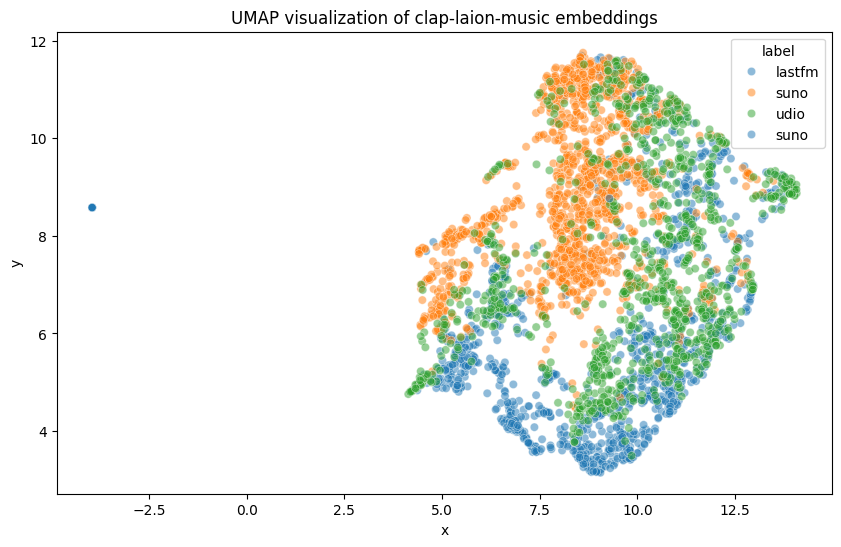

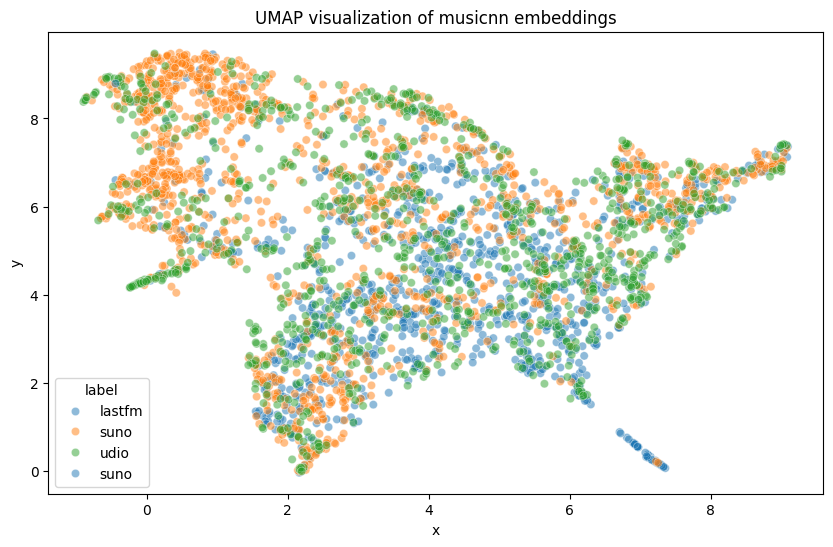

ae93629f99a158811e455341f812fc63 lastfm
d5481ff17db0e9e8cda69bd0dcb0ec1c lastfm
bf4f308b6a8f6b6ae0a8571edbfb134a lastfm
30be773bf08b22a74f3e46a665ad48cd lastfm
7c04c37d83846577ddf18a43a92035f5 lastfm
e24b3a2d-4601-4e75-87c3-cec7125b1fa7 suno
ac718ede-69c6-489d-86ec-315912b04480 suno
fb3d6e80-cff0-4312-84da-776a3a8ac4d7 suno
a1852abd-fedf-4573-a2b6-a13a882b3a1a suno
76bffb78-8ce1-4da2-9442-71778ff958d5 suno
45b9c4f2-596e-4f39-b4b2-b609bbeda484 suno
5ac3f39d-11af-4d78-9cf0-afb424be5cc7 suno
2ce1071a-e4a8-43e4-a1c3-0f104d755829 suno
ce1df770-ec55-4c6f-8fe8-0a7d5f546f60 suno
ae2bb1ab-1676-4e5b-806d-3fa512743d89 suno
78c02937-9b28-49fa-9ad3-1e9c8bcadc93 suno
ecf93e8c-3d10-47ef-aa02-7e797d1ea471 suno
fef34c7c-a6a1-4861-865c-66b11b1cacb4 suno
239cf695-5fbc-4e90-a2c6-52deb9501ceb suno
cadb5f2f-99b1-4f53-906c-f86bad00186f suno
780f1394-3cea-4ddf-a34b-7dbb0cf4cab1 suno
637f6f3f-e75b-432a-bda1-f4c61f440648 suno
8be7bf7d-d148-4557-a0c7-aeaf66d9d678 suno
a2880318-4dfc-4873-8b3c-ebd548f302f1 suno
df

In [10]:
df = pd.DataFrame(embedding_clap, columns=['x', 'y'])
df['label'] = y_clap

all_files = lastfm_files + suno_files + udio_files
# print the names of the files that have negative x values
for i in range(len(embedding_clap)):
    if embedding_clap[i][0] < 0:
        print(all_files[i], y_clap[i])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.5)
# all_files == a2eedb04-74da-4c11-bb9a-f1be61308e87 is always misclassified, plot it in red
sns.scatterplot(data=df[df.index == all_files.index('a2eedb04-74da-4c11-bb9a-f1be61308e87')], x='x', y='y', hue='label', palette='tab10', alpha=0.5, color='red')
plt.title('UMAP visualization of clap-laion-music embeddings')
plt.show()

df = pd.DataFrame(embedding_musicnn, columns=['x', 'y'])
df['label'] = y_musicnn

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab10', alpha=0.5)
# all_files == a2eedb04-74da-4c11-bb9a-f1be61308e87 is always misclassified, plot it in red
sns.scatterplot(data=df[df.index == all_files.index('a2eedb04-74da-4c11-bb9a-f1be61308e87')], x='x', y='y', hue='label', palette='tab10', alpha=0.5, color='red')
plt.title('UMAP visualization of musicnn embeddings')
plt.show()

# print the names of the files that have negative x values
for i in range(len(embedding_musicnn)):
    if embedding_musicnn[i][0] < 0:
        print(all_files[i], y_musicnn[i])